In [200]:
import zipfile
import os
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

### Домашнее задание 1, часть 2

Классификация изображений (пролив/не пролив)

In [201]:
if 'dataset' not in os.listdir():
    with zipfile.ZipFile('dataset.zip') as zipfile:
        zipfile.extractall()

#### Загрузка данных для обучения

In [202]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_size=(28, 28)):
        self.img_dir = img_dir
        self.transform = transform
        self.target_size = target_size
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith(('jpg',))]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path)
        image = transforms.functional.resize(image, self.target_size)
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [203]:
tensor_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_dataset = ImageDataset(
    img_dir='dataset/train',
    transform=tensor_transform,
    target_size=(28, 28)
)

test_positive_dataset = ImageDataset(
    img_dir='dataset/proliv',
    transform=tensor_transform,
    target_size=(28, 28)
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_positive_loader = torch.utils.data.DataLoader(test_positive_dataset, batch_size=32, shuffle=False)

#### Класс модели

In [204]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#### Обучение

In [205]:
def train_autoencoder(autoencoder, train_loader, num_epochs):
    optimizer = torch.optim.Adam(autoencoder.parameters())
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):
        for data in train_loader:
            data = data.view(data.size(0), -1)
            
            outputs = autoencoder(data)
            loss = criterion(outputs, data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Оптимальное кол-во эпох - 4

In [206]:
autoencoder = AutoEncoder()
train_autoencoder(autoencoder, train_loader, num_epochs=4)

Epoch [1/4], Loss: 0.0014
Epoch [2/4], Loss: 0.0015
Epoch [3/4], Loss: 0.0014
Epoch [4/4], Loss: 0.0013


#### Оценка на изображениях с проливами

Подбираем оптимальный threshold вручную (оптимальное значение получилось среднее по MSE + 3 сигмы)

In [207]:
def evaluate_threshold(autoencoder, train_loader, test_loader):

    autoencoder.eval()
    criterion = torch.nn.MSELoss(reduction='none')
    
    train_losses = []
    with torch.no_grad():
        for data in train_loader:
            data = data.view(data.size(0), -1)
            outputs = autoencoder(data)
            loss = criterion(outputs, data)
            train_losses.extend(loss.mean(dim=1).tolist())

    test_losses = []
    with torch.no_grad():
        for data in test_loader:
            data = data.view(data.size(0), -1)
            outputs = autoencoder(data)
            loss = criterion(outputs, data)
            test_losses.extend(loss.mean(dim=1).tolist())
    
    threshold = np.mean(train_losses) + 3 * np.std(train_losses)

    true_positives = sum(l > threshold for l in test_losses)
    false_negatives = len(test_losses) - true_positives
    false_positives = sum(l > threshold for l in train_losses)
    
    print(f"Suggested Threshold: {threshold:.4f}")
    print(f'False negatives: {false_negatives}/{len(test_losses)}')
    print(f"Positive samples detected as anomalies: {true_positives}/{len(test_losses)}")
    print(f"Negative samples detected as anomalies: {false_positives}/{len(train_losses)}")
    
    return threshold, train_losses, test_losses

In [208]:
threshold, train_losses, test_losses = evaluate_threshold(
    autoencoder, 
    train_loader,
    test_positive_loader
)

Suggested Threshold: 0.0045
False negatives: 92/154
Positive samples detected as anomalies: 62/154
Negative samples detected as anomalies: 197/10000


#### Оценка на тестовом датасете с отметками

In [209]:
class LabeledImageDataset(Dataset):
    def __init__(self, img_dir, label_dict, transform=None, target_size=(28, 28)):
        self.img_dir = img_dir
        self.transform = transform
        self.target_size = target_size
        self.label_dict = label_dict
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith(('jpg', 'png')) and f in label_dict]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path)
        image = transforms.functional.resize(image, self.target_size)
        
        if self.transform:
            image = self.transform(image)
            
        label = self.label_dict[self.image_files[idx]]
        return image, label

In [210]:
def load_labels(label_file):
    labels = {}
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                filename, label = parts
                labels[filename] = int(label)
    return labels

In [211]:
def evaluate_model(autoencoder, test_img_dir, label_file, threshold):

    autoencoder.eval()
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    label_dict = load_labels(label_file)
    
    test_dataset = LabeledImageDataset(
        img_dir=test_img_dir,
        label_dict=label_dict,
        transform=transform,
        target_size=(28, 28)
    )
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    criterion = torch.nn.MSELoss(reduction='none')
    
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.view(data.size(0), -1)
            outputs = autoencoder(data)
            loss = criterion(outputs, data).mean(dim=1)
            
            predictions = (loss > threshold).cpu().numpy()
            
            for pred, label in zip(predictions, labels):
                if label == 1:
                    if pred:
                        true_positives += 1
                    else:
                        false_negatives += 1
                else:
                    if not pred:
                        true_negatives += 1
                    else:
                        false_positives += 1
    
    total_positives = true_positives + false_negatives
    total_negatives = true_negatives + false_positives
    
    tpr = true_positives / total_positives if total_positives > 0 else 0
    tnr = true_negatives / total_negatives if total_negatives > 0 else 0
    
    print(f"Threshold: {threshold:.4f}")
    print(f"True Positives (TP): {true_positives}")
    print(f"False Negatives (FN): {false_negatives}")
    print(f"True Negatives (TN): {true_negatives}")
    print(f"False Positives (FP): {false_positives}")
    print(f"True Positive Rate: {tpr:.4f}")
    print(f"True Negative Rate: {tnr:.4f}")
    
    return {
        'TP': true_positives,
        'FN': false_negatives,
        'TN': true_negatives,
        'FP': false_positives,
        'TPR': tpr,
        'TNR': tnr,
    }

In [212]:
results = evaluate_model(autoencoder, "dataset/test/imgs", "dataset/test/test_annotation.txt", threshold)

Threshold: 0.0045
True Positives (TP): 96
False Negatives (FN): 33
True Negatives (TN): 3428
False Positives (FP): 237
True Positive Rate: 0.7442
True Negative Rate: 0.9353


#### Используем ROC-AUC для подбора оптимального порога

In [213]:
def compute_reconstruction_errors(autoencoder, test_loader):

    autoencoder.eval()
    criterion = torch.nn.MSELoss(reduction='none')
    errors = []
    labels = []
    
    with torch.no_grad():
        for data, label in test_loader:
            data = data.view(data.size(0), -1)
            outputs = autoencoder(data)
            loss = criterion(outputs, data).mean(dim=1)
            errors.extend(loss.cpu().numpy())
            labels.extend(label.cpu().numpy())
    
    return np.array(errors), np.array(labels)

In [214]:
def plot_roc_curve(autoencoder, test_loader):
    errors, labels = compute_reconstruction_errors(autoencoder, test_loader)
    
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    return fpr, tpr, thresholds, roc_auc

In [215]:
def evaluate_with_roc(autoencoder, test_img_dir, label_file):

    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor()
    ])
    
    label_dict = load_labels(label_file)
    test_dataset = LabeledImageDataset(test_img_dir, label_dict, transform, (28, 28))
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    errors, labels = compute_reconstruction_errors(autoencoder, test_loader)
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    plot_roc_curve(autoencoder, test_loader)
    results_at_optimal = evaluate_model(autoencoder, test_img_dir, label_file, optimal_threshold)
    
    return {
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'auc': roc_auc,
        'optimal_threshold': optimal_threshold,
        'metrics_at_optimal': results_at_optimal,
    }

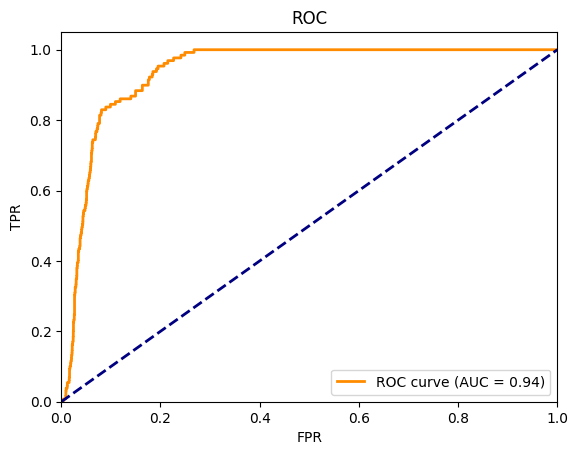

Threshold: 0.0027
True Positives (TP): 122
False Negatives (FN): 7
True Negatives (TN): 2950
False Positives (FP): 715
True Positive Rate: 0.9457
True Negative Rate: 0.8049
AUC: 0.9375
Optimal Threshold: 0.0027


In [216]:
results = evaluate_with_roc(autoencoder, "dataset/test/imgs", "dataset/test/test_annotation.txt")
print(f"AUC: {results['auc']:.4f}")
print(f"Optimal Threshold: {results['optimal_threshold']:.4f}")